In [3]:
from __future__ import print_function, division

import nsfg
import survival

import thinkstats2
import thinkplot

import pandas
import numpy
from lifelines import KaplanMeierFitter
from collections import defaultdict

import matplotlib.pyplot as pyplot
import chap01soln

%matplotlib inline

In [4]:
resp = chap01soln.ReadFemResp()

In [5]:
resp.cmmarrhx.replace([9997,9998,9999], np.nan, inplace=True)
resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

In [6]:
complete = resp[resp.evrmarry==1].agemarry
ongoing = resp[resp.evrmarry==0].age

In [8]:
class SurvivalFunction(object):
    """Represents a survival function."""

    def __init__(self, cdf, label=''):
        self.cdf = cdf
        self.label = label or cdf.label

    @property
    def ts(self):
        return self.cdf.xs

    @property
    def ss(self):
        return 1 - self.cdf.ps

    def __getitem__(self, t):
        return self.Prob(t)

    def Prob(self, t):
        """Returns S(t), the probability that corresponds to value t.

        t: time

        returns: float probability
        """
        return 1 - self.cdf.Prob(t)

    def Probs(self, xs):
        """Gets probabilities for a sequence of values."""
        return [self.Prob(x) for x in xs]

    def Mean(self):
        """Mean survival time."""
        return self.cdf.Mean()

    def Items(self):
        """Sorted list of (t, s) pairs."""
        return zip(self.ts, self.ss)

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        returns: tuple of (sorted times, survival function)
        """
        return self.ts, self.ss

    def MakeHazard(self, label=''):
        """Computes the hazard function.

        sf: survival function

        returns: Pmf that maps times to hazard rates
        """
        ss = self.ss
        lams = {}
        for i, t in enumerate(self.ts[:-1]):
            hazard = (ss[i] - ss[i+1]) / ss[i]
            lams[t] = hazard

        return HazardFunction(lams, label=label)

    def MakePmf(self, filler=None):
        """Makes a PMF of lifetimes.

        filler: value to replace missing values

        returns: Pmf
        """
        pmf = thinkstats2.Pmf()
        for val, prob in self.cdf.Items():
            pmf.Set(val, prob)

        cutoff = self.cdf.ps[-1]
        if filler is not None:
            pmf[filler] = 1-cutoff

        return pmf

    def RemainingLifetime(self, filler=None, func=thinkstats2.Pmf.Mean):
        """Computes remaining lifetime as a function of age.

        func: function from conditional Pmf to expected liftime

        returns: Series that maps from age to remaining lifetime
        """
        pmf = self.MakePmf(filler=filler)
        d = {}
        for t in sorted(pmf.Values())[:-1]:
            pmf[t] = 0
            pmf.Normalize()
            d[t] = func(pmf) - t
            #print(t, d[t])

        return pandas.Series(d)

In [9]:
class HazardFunction(object):
    """Represents a hazard function."""

    def __init__(self, d, label=''):
        """Initialize the hazard function.

        d: dictionary (or anything that can initialize a series)
        label: string
        """
        self.series = pandas.Series(d)
        self.label = label

    def __getitem__(self, t):
        return self.series[t]

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        returns: tuple of (sorted times, hazard function)
        """
        return self.series.index, self.series.values

    def MakeSurvival(self, label=''):
        """Makes the survival function.

        returns: SurvivalFunction
        """
        ts = self.series.index
        ss = (1 - self.series).cumprod()
        cdf = thinkstats2.Cdf(ts, 1-ss)
        sf = SurvivalFunction(cdf, label=label)
        return sf

    def Extend(self, other):
        """Extends this hazard function by copying the tail from another.

        other: HazardFunction
        """
        last = self.series.index[-1]
        more = other.series[other.series.index > last]
        self.series = pandas.concat([self.series, more])

In [10]:
def EstimateHazardFunction(complete, ongoing, label='', shift=1e-7):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    shift: presumed additional survival of ongoing
    """
    # pmf and sf of complete lifetimes
    n = len(complete)
    hist_complete = thinkstats2.Hist(complete)
    sf_complete = SurvivalFunction(thinkstats2.Cdf(complete))

    # sf for ongoing lifetimes
    # The shift is a regrettable hack needed to deal with simultaneity.
    # If a case is complete at some t and another case is ongoing
    # at t, we presume that the ongoing case exceeds t+shift.
    m = len(ongoing)
    cdf = thinkstats2.Cdf(ongoing).Shift(shift)
    sf_ongoing = SurvivalFunction(cdf)

    lams = {}
    for t, ended in sorted(hist_complete.Items()):
        at_risk = ended + n * sf_complete[t] + m * sf_ongoing[t]
        lams[t] = ended / at_risk
        #print(t, ended, n * sf_complete[t], m * sf_ongoing[t], at_risk)

    return HazardFunction(lams, label=label)

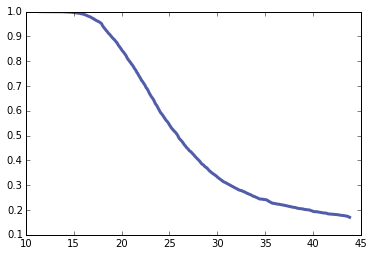

In [13]:
thinkplot.Plot(EstimateHazardFunction(complete, ongoing).MakeSurvival())